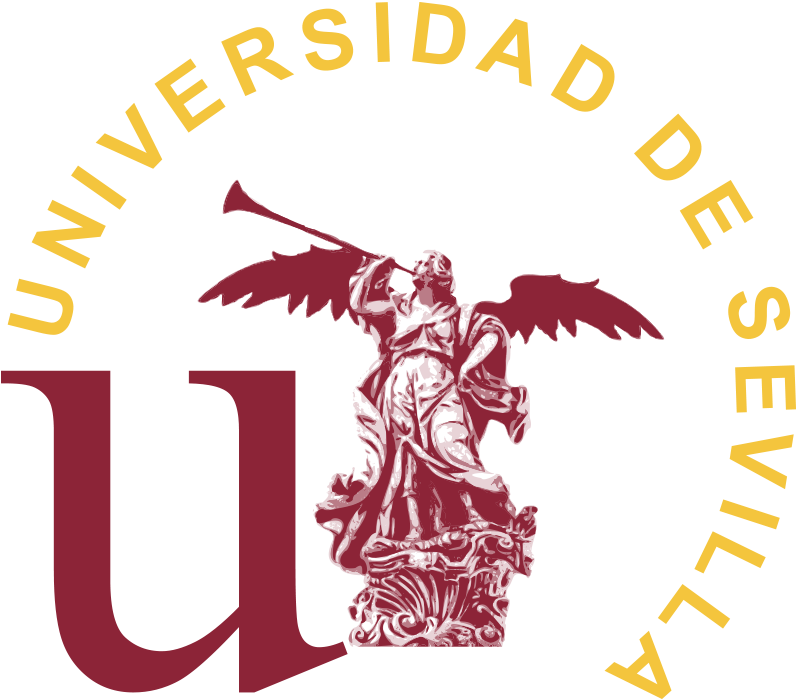

# Visión por computador aplicada a la robótica
## Autores
Alejandro Barranco Ledesma<br>Eliseo Romero Marín

## Configuración inicial
La compatibilidad de Python y en particular Pytorch con dispositivos GPU es algo compleja en la actualidad, por cuestiones de arquitectura hardware. Por ello, se recomienda generar un kernel concreto con una versión de Python estable con las librerías requeridas y una versión de Pytorch y Torchvision compatibles con el dispositivo concreto.

Al realizar este trabajo, para utilizar una NVIDIA GeForce RTX 5060 Laptop GPU fue necesario forzar la versión cu128 (nightly) de Pytorch.

En un **Anaconda prompt**, deben ejecutarse uno a uno estos comandos para poder generar con éxito el kernel **Python (yolo_gpu)**.

Si todo ha sido exitoso, ya dentro del notebook debe seleccionarse el kernel **Python (yolo_gpu)**. A continuación, importamos torch y validamos la versión de Torch y su **compatibilidad con el driver/gpu** del sistema utilizado.

In [1]:
import torch

print("Versión Torch: " + torch.__version__)
print("Versión CUDA: " + torch.version.cuda)
print("Torch detecta CUDA: " + str(torch.cuda.is_available()))
if torch.cuda.is_available():
    print("Dispositivo GPU: " + torch.cuda.get_device_name(0))

Versión Torch: 2.11.0.dev20260112+cu128
Versión CUDA: 12.8
Torch detecta CUDA: True
Dispositivo GPU: NVIDIA GeForce RTX 5060 Laptop GPU


## Clasificación YOLO en imágenes 2D

In [2]:
from pathlib import Path

import yaml
from ultralytics import YOLO

**Dataset utilizado: HomeObjects-3K**

El dataset HomeObjects-3K es un conjunto de datos de detección de objetos diseñado para entornos indoor, especialmente orientado a aplicaciones de robótica móvil y robótica de servicio. El dataset contiene imágenes de escenas domésticas reales con anotaciones en formato YOLO, lo que permite su uso directo en modelos de detección de objetos en tiempo real sin necesidad de realizar conversiones adicionales.

Este dataset incluye 12 clases de objetos comunes en entornos domésticos, entre las que se encuentran: bed, sofa, chair, table, lamp, tv, laptop, wardrobe, window, door, potted plant y photo frame. Estas clases son especialmente relevantes para tareas de percepción visual en robótica indoor, como navegación autónoma, evitación de obstáculos y comprensión del entorno.

El conjunto de datos se encuentra preprocesado y organizado en formato YOLO-ready, con las imágenes y las anotaciones de bounding boxes normalizadas en archivos .txt, compatibles directamente con la librería Ultralytics YOLO.

**División del dataset**

El dataset está dividido en los siguientes subconjuntos:

- Train: conjunto de entrenamiento utilizado para el aprendizaje del modelo, compuesto por aproximadamente 2.285 imágenes.
- Validation (Val): conjunto de validación empleado para evaluar el rendimiento del modelo durante el proceso de entrenamiento y seleccionar el mejor modelo, compuesto por aproximadamente 404 imágenes.
- Test: el dataset no proporciona un conjunto de test independiente. Por este motivo, las métricas de rendimiento se reportan sobre el conjunto de validación, una práctica habitual en trabajos académicos y exploratorios.

Esta división permite entrenar y evaluar modelos de detección de objetos de manera eficiente, manteniendo un equilibrio entre tamaño del dataset, calidad de las anotaciones y estabilidad de las métricas obtenidas.

**Organización local del dataset**

Para este trabajo, el dataset se organiza manualmente dentro del proyecto siguiendo la estructura estándar requerida por YOLO, de modo que las rutas quedan explícitas y se evita cualquier descarga automática durante el entrenamiento:

```
data/yolo/
  ├─ datasets/
  │   └─ homeobjects-3K/
  │       ├─ images/
  │       │   ├─ train/
  │       │   └─ val/
  │       └─ labels/
  │           ├─ train/
  │           └─ val/
  ├─ HomeObjects-3K.yaml
  └─ runs/
```

El archivo de configuración HomeObjects-3K.yaml define explícitamente la ruta local al dataset mediante el parámetro path, junto con los subconjuntos de entrenamiento y validación, garantizando control total sobre la estructura de datos utilizada y una mayor reproducibilidad experimental.

**Descarga y disponibilidad**

El dataset HomeObjects-3K forma parte del conjunto de datasets oficiales mantenidos por la empresa Ultralytics y es de acceso público y gratuito. En este trabajo se utiliza una copia local del dataset junto con su archivo de configuración YAML, evitando descargas automáticas y haciendo explícita la estructura de datos empleada.

La documentación oficial del dataset se encuentra disponible en el siguiente enlace:  
https://docs.ultralytics.com/datasets/detect/homeobjects-3k/

Descarga:
https://github.com/ultralytics/assets/releases/download/v0.0.0/homeobjects-3K.zip

<img src="https://github.com/ultralytics/docs/releases/download/0/homeobjects-3k-dataset-sample.avif" />

In [3]:
# Folders
OUT_ROOT = Path("./data/yolo")
RUNS_DIR = OUT_ROOT / "runs"
EXPORT_DIR = OUT_ROOT / "model"  # salida estable
EXPORT_MODEL_NAME = "best_model.pt"    # export modelo
YAML_DATA = OUT_ROOT / "HomeObjects-3K.yaml"

# Entrenamiento
MODEL = "yolo11s" # Modelo a utilizar
IMGSZ = 640 # Ancho de las imágenes
EPOCHS = 100
BATCH = 8
RUN_NAME = "homeobjects_yolo"

In [4]:
def pick_device():
    # Ultralytics acepta 0 / "cpu"
    try:
        import torch
        return 0 if torch.cuda.is_available() else "cpu"
    except Exception:
        return "cpu"

In [5]:
# Train
model = YOLO(MODEL)
results = model.train(
    data=YAML_DATA,
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    device=pick_device(),
    project=str(RUNS_DIR),
    seed=0, # reproducible
    exist_ok=True,
    name=RUN_NAME,
    patience=10,
    workers=0,        
    cache=False,      
    verbose=True,
)

New https://pypi.org/project/ultralytics/8.3.252 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.240  Python-3.10.19 torch-2.11.0.dev20260112+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Laptop GPU, 8151MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data\yolo\HomeObjects-3K.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=hom

Al finalizar el entrenamiento, **el mejor de los modelos evaluados durante las diferentes Epochs** se almacena en ./data/yolo/runs/homeobjects_yolo/weights/best.pt. Esto facilita la portabilidad y el uso del modelo entrenado en cualquier otro dispositivo.
    

In [16]:
# Cargar modelo preentrenado
model = YOLO("./data/yolo/runs/homeobjects_yolo/weights/best.pt")


image 1/1 C:\Users\AlejandroBarrancoLed\Desktop\MULCIA\IAR\data\yolo\datasets\homeobjects-3K\images\val\living_room_1p (357).jpg: 384x640 1 chair, 1 table, 2 potted plants, 18.7ms
Speed: 2.4ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


(-0.5, 1279.5, 716.5, -0.5)

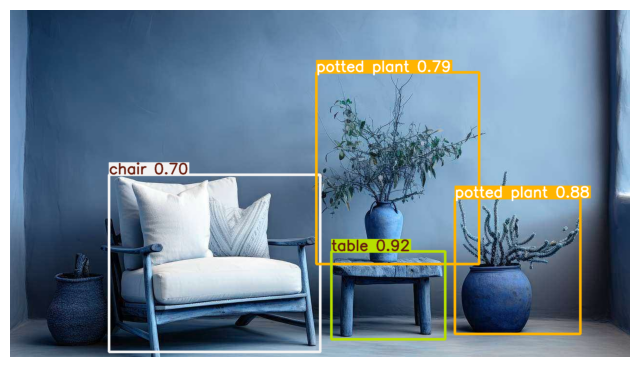

In [17]:
import matplotlib.pyplot as plt

# Predicción sobre una imagen de ejemplo
results = model("./data/yolo/datasets/homeobjects-3K/images/val/living_room_1p (357).jpg")

img = results[0].plot()  # numpy array con boxes dibujadas

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")

Consultando el primer elemento del array results (results[0]) se obtienen los datos de la detección concreta (boxes, ids, velocidad de procesamiento...). Esto es especialmente útil para integrarlo en sistemas de robótica.

In [18]:
results[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'bed', 1: 'sofa', 2: 'chair', 3: 'table', 4: 'lamp', 5: 'tv', 6: 'laptop', 7: 'wardrobe', 8: 'window', 9: 'door', 10: 'potted plant', 11: 'photo frame'}
obb: None
orig_img: array([[[ 81, 116, 149],
        [ 80, 115, 148],
        [ 79, 114, 147],
        ...,
        [167, 204, 232],
        [163, 200, 228],
        [155, 192, 220]],

       [[ 81, 116, 149],
        [ 80, 115, 148],
        [ 79, 114, 147],
        ...,
        [167, 204, 232],
        [164, 201, 229],
        [156, 193, 221]],

       [[ 81, 116, 149],
        [ 80, 115, 148],
        [ 79, 114, 147],
        ...,
        [166, 203, 231],
        [164, 201, 229],
        [158, 195, 223]],

       ...,

       [[111, 126, 145],
        [111, 126, 145],
        [110, 125, 144],
        ...,
        [122, 121, 125],
        [122, 121, 125],
        [122, 121, 125]],

       [